<a href="https://colab.research.google.com/github/dqniellew1/DSCI330/blob/master/What_is_a_CT_scan%2C_exactly%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
drive_dir = 'drive/My Drive/dlwpt-code/data/'

In [ ]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

Learning about you problem space is crucial! We have to combine insights into the space with intuition about neural network behavior.

**What is a CT scan, exactly**

They are essentially 3-D x-rays, represented as a 3-D array of single channel data.

Voxel is the 3-D equivalent to the the familiar 2-D pixel (Height x Width), rather than an area, and will typically be arranged in a 3-D grid to represent a field of data. Each of those dimensions will have a measurable distance associated. Often, voxels are cubic, but for this chapter we will be dealing with voxels that are rectangular prisms.


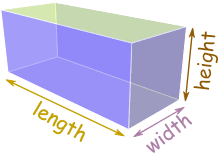

Each voxel of a CT scan has a numeric value that roughly corrresponds to the average mass density of the matter contained inside. Most visualizations of that data have **high-density** materials like bones and metal implants as **white**, **low-density air** and lung tissue as **black** and fat and tissue as various shades of **gray in between**. This ends up looking somewhat similar to an x-ray with some key differences.

 The primary difference between CT scans and x-rays is that while an x-ray is a projection of 3D intensity onto a 2D plane, a CT scam retains the 3rd dimension of the data. This allows us to render the data in a variety of ways.

From the image above we can see that length represents the patient's head to foot. So how they are measured along the two other axis (height and width) are different. This explains why the voxel is not cubic and also ties into how we approach massaging our data.

Steps we will take for our problem:
![alt text](https://dpzbhybb2pdcj.cloudfront.net/stevens2/v-13/Figures/p2_mental_model.png)

1. Load our raw CT scan data into a form that we can use with PyTorch
2. Identify the voxels of potentially malignant tumors in the lungs using PyTorch to implement segmentation. (This is roughly akin to producing a heatmap of areas that should be fed into our classifier)
  - This will allows us to focus on **potential malignant tumors** inside the lungs, and ignore huge swathes of uninteresting anatomy. (can't have lung cancer in the stomach)
  - Generally, being able to **focus on a single, small task is going to be best while learning.** With experience, there are some situations where more complicated model structures can yield superlative results. But first gotta master basic building blocks.
3. Cluster interesting voxels into lumps called nodules. Here, we will be **finding the rough center of each hotspot on our heatmap.**
  - Each nodule can be located with by the **index, row and column of their center point**. We do this to present a simple constrained problem to the final classifier.
  - This will not involve PyTorch directly, which is why we've this out into a separate step.
  - Often when working with multi-step solutions, there will be non-deep-learning glue steps between the larger, deep-learning-powered portions of the project.
4. Classify identified nodules as benign or malignant using 3D convolution.
  - This will be similar in concept to the 2D convolutions earlier.
  - The features that determine malignancy of a tumor are local to the tumor in question, so this approach should provide a good balance between limiting input data size without excluding relevant information.
  - Making scope-limiting decisions like this can help each individual task constrained, which can help by limiting the amount of things to examine when troubleshooting.
5. Diagnose the patient using the combined per-nodule classifications.
  - We will be taking a simple maximum of the per-tumor malignancy predictions, as a patient only needs one tumor to be malignant to have cancer.
  - \* Other projects might want to use different ways of aggregating the per-instance predictions into a file score.

**What is a nodule?**

A nodule is any of the myriad lumps and bumps that might appear inside of someone's lungs. Some are problematic from a health's perspective, some are not. 

The key part is this: **the cancers that we are trying to detect will always be nodules; one either suspended in the very non-dense tissue of the lung, or attached to the lung wall.**

That means we can limit our classifier to only nodules, rather having it examine all tissue. Being able to restrict the scope of expected inputs will help our classifier learn the task at hand.

\* This is another example of how the underlying deep learning techniques we'll use are universal, but they can't be applied blindly. **We need to understand the field we're working in to make choices that will serve us well.**